<a href="https://colab.research.google.com/github/annshita/Alzheimer-Stage-Prediction/blob/main/ADNI_ConvNext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
root_dir = '/content/drive/MyDrive/Datasets/ADNI_axial_80'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms, datasets
import torchvision
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len([f for f in files if f.lower().endswith(('png', 'jpg', 'jpeg'))])
    return count

train_count = count_images(train_dir)
test_count = count_images(test_dir)

print(f"Total training images: {train_count}")
print(f"Total testing images: {test_count}")

def show_sample_images(dir_path, n=5):
    classes = os.listdir(dir_path)
    for cls in classes:
        cls_path = os.path.join(dir_path, cls)
        img_files = [f for f in os.listdir(cls_path) if f.endswith(('jpg', 'png', 'jpeg'))]
        print(f"Class: {cls}")
        fig, axs = plt.subplots(1, n, figsize=(15, 5))
        for i in range(n):
            img = Image.open(os.path.join(cls_path, random.choice(img_files)))
            axs[i].imshow(img, cmap='gray')
            axs[i].axis('off')
        plt.show()

show_sample_images(train_dir)

Using device: cuda
Total training images: 0
Total testing images: 0


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Datasets/ADNI_axial_80/train'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python matplotlib

!git clone https://github.com/facebookresearch/segment-anything.git
%cd segment-anything
!mkdir models
!wget -P models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

%cd ..

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3cvwlk5o
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3cvwlk5o
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
fatal: destination path 'segment-anything' already exists and is not an empty directory.
/content/segment-anything
mkdir: cannot create directory ‘models’: File exists
--2025-04-13 10:00:41--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.108, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘models/sam_vit_b_01ec64.pth.1’



Image: AD023_S_0139b121.png


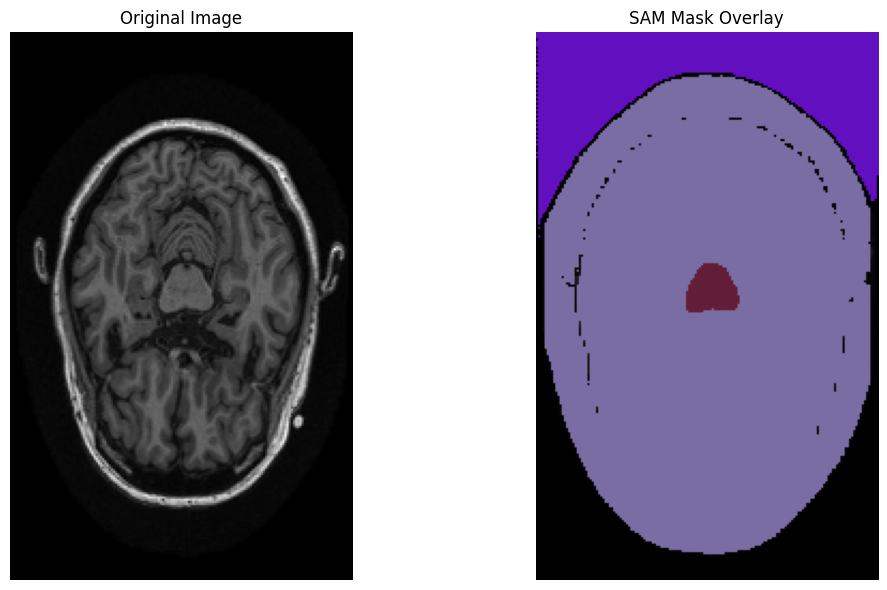

Image: ADNI_023_S_1289_MR_MPR-R__GradWarp__B1_Correction_Br_20070322183801893_S26852_I46431_slice_108.png


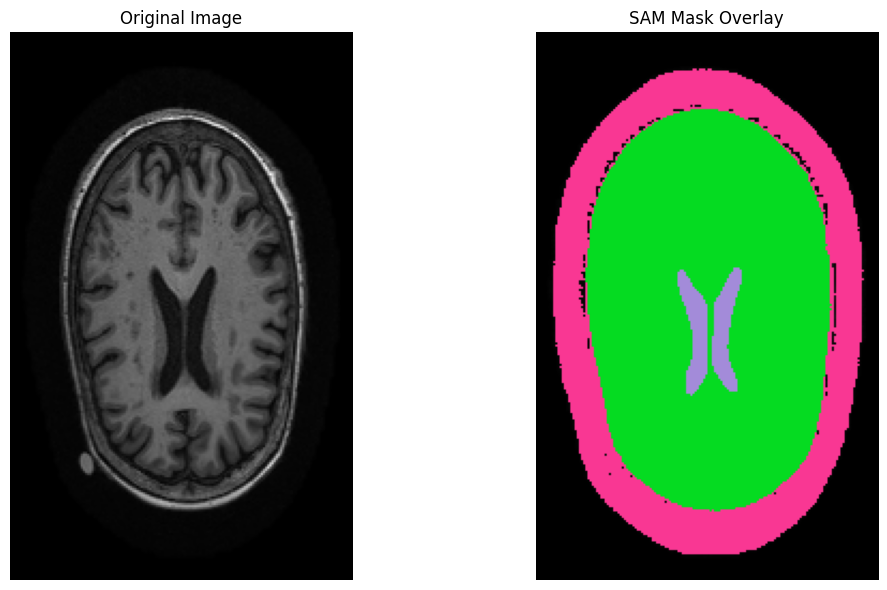

Image: ADNI_130_S_0956_MR_MPR____N3__Scaled_Br_20070210223200198_S22511_I39200_slice_108.png


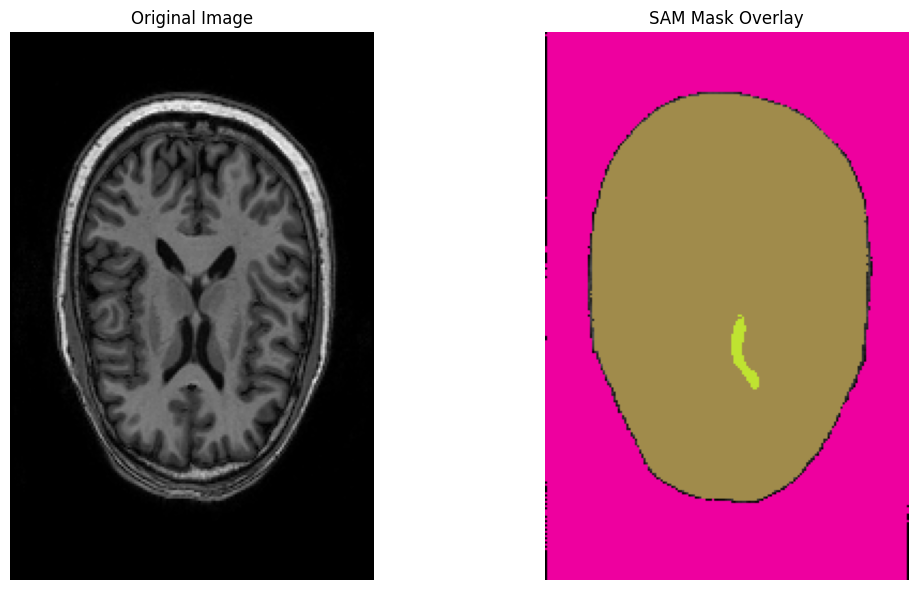

In [ ]:
def apply_sam_to_image_side_by_side(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image_rgb)

    sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)

    mask_overlay = image_rgb.copy()
    for mask in sorted_masks[:3]:
        mask_image = mask['segmentation']
        color = np.random.randint(0, 255, (1, 3), dtype=np.uint8).tolist()[0]
        mask_overlay[mask_image] = color

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image_rgb)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(mask_overlay)
    axs[1].set_title("SAM Mask Overlay")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

for img_name in random.sample(sample_images, 3):
    print(f"Image: {img_name}")
    apply_sam_to_image_side_by_side(os.path.join(sample_path, img_name))


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import convnext_tiny
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

Classes: ['AD', 'CN']


In [ ]:
model = convnext_tiny(pretrained=True)
model.classifier[2] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[2].in_features, num_classes)
)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-19-148b64f37ed6>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

def evaluate(model, loader):
    model.eval()
    correct, total, loss_total = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            loss_total += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return loss_total / len(loader), correct / total

epochs = 10  # Can increase later

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100*correct/total)

    # Log after each epoch
    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"\nEpoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

Epoch [1/10]:   0%|          | 0/198 [00:00<?, ?it/s]<ipython-input-20-f89bb61f97e1>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch [1/10]: 100%|██████████| 198/198 [00:39<00:00,  4.95it/s, acc=68.8, loss=0.327]
<ipython-input-20-f89bb61f97e1>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 1: Train Loss=0.5516, Train Acc=0.6877 | Test Loss=0.3200, Test Acc=0.8596


Epoch [2/10]: 100%|██████████| 198/198 [00:28<00:00,  6.91it/s, acc=84.7, loss=0.0696]



Epoch 2: Train Loss=0.3299, Train Acc=0.8468 | Test Loss=0.4326, Test Acc=0.7928


Epoch [3/10]: 100%|██████████| 198/198 [00:28<00:00,  7.03it/s, acc=91.2, loss=0.0605]



Epoch 3: Train Loss=0.2106, Train Acc=0.9117 | Test Loss=0.0813, Test Acc=0.9679


Epoch [4/10]: 100%|██████████| 198/198 [00:28<00:00,  6.88it/s, acc=93.8, loss=0.618]



Epoch 4: Train Loss=0.1535, Train Acc=0.9377 | Test Loss=0.0607, Test Acc=0.9759


Epoch [5/10]: 100%|██████████| 198/198 [00:28<00:00,  6.99it/s, acc=95.9, loss=0.125]



Epoch 5: Train Loss=0.1048, Train Acc=0.9592 | Test Loss=0.0333, Test Acc=0.9866


Epoch [6/10]: 100%|██████████| 198/198 [00:28<00:00,  7.03it/s, acc=96.9, loss=0.175]



Epoch 6: Train Loss=0.0855, Train Acc=0.9687 | Test Loss=0.0087, Test Acc=1.0000


Epoch [7/10]: 100%|██████████| 198/198 [00:28<00:00,  6.93it/s, acc=98.1, loss=0.0239]



Epoch 7: Train Loss=0.0505, Train Acc=0.9807 | Test Loss=0.0425, Test Acc=0.9826


Epoch [8/10]: 100%|██████████| 198/198 [00:29<00:00,  6.82it/s, acc=97.5, loss=0.0504]



Epoch 8: Train Loss=0.0667, Train Acc=0.9753 | Test Loss=0.0129, Test Acc=0.9973


Epoch [9/10]: 100%|██████████| 198/198 [00:29<00:00,  6.70it/s, acc=97.8, loss=1.13]



Epoch 9: Train Loss=0.0619, Train Acc=0.9782 | Test Loss=0.0427, Test Acc=0.9786


Epoch [10/10]: 100%|██████████| 198/198 [00:27<00:00,  7.10it/s, acc=98.8, loss=0.00948]



Epoch 10: Train Loss=0.0382, Train Acc=0.9880 | Test Loss=0.0143, Test Acc=0.9933


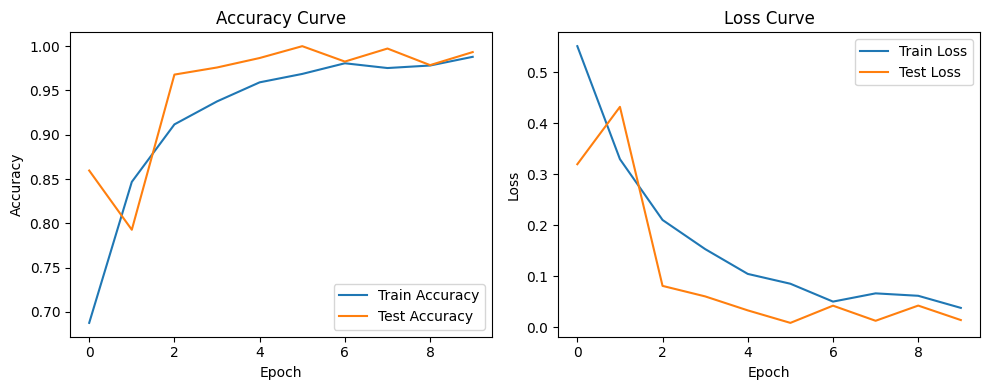

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.tight_layout()
plt.show()

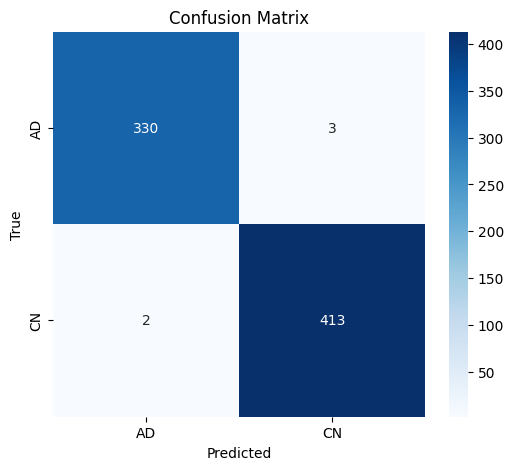


Classification Report:
              precision    recall  f1-score   support

          AD       0.99      0.99      0.99       333
          CN       0.99      1.00      0.99       415

    accuracy                           0.99       748
   macro avg       0.99      0.99      0.99       748
weighted avg       0.99      0.99      0.99       748



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification metrics
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

In [ ]:
# Specificity calculation
def calculate_metrics(cm):
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)

    accuracy = TP.sum() / cm.sum()
    precision = np.mean(TP / (TP + FP + 1e-8))
    recall = np.mean(TP / (TP + FN + 1e-8))  # Sensitivity
    specificity = np.mean(TN / (TN + FP + 1e-8))
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    return accuracy, precision, recall, specificity, f1

acc, prec, sens, spec, f1 = calculate_metrics(cm)
print(f"\nMetrics Summary:")
print(f"Accuracy:    {acc:.4f}")
print(f"Precision:   {prec:.4f}")
print(f"Sensitivity: {sens:.4f}")
print(f"Specificity: {spec:.4f}")
print(f"F1 Score:    {f1:.4f}")


Metrics Summary:
Accuracy:    0.9933
Precision:   0.9934
Sensitivity: 0.9931
Specificity: 0.9931
F1 Score:    0.9932
